<a href="https://colab.research.google.com/github/ElahehJafarigol/AMR-Benchmark/blob/main/MCNeT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Modulation Classification

**MaxWav LLc**

Spring 2024

In this notebook we will explore some deep learning models to classify data based on their modulation type.

**Dataset:** RadioML 2026.10A

**Contributors:** Elaheh Jafarigol

###Imports

In [ ]:
# Copy the file to the current directory.
!cp /content/drive/MyDrive/Colab_Notebooks/DeepSig/loader.py .

In [ ]:
from loader import DataSet
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn
import random
import tensorflow as tf
import pickle
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from scipy.signal import spectrogram
np.random.seed(42)
tf.random.set_seed(1234)

In [ ]:
# Load the dataset from the pickle file
dataset = DataSet('/content/drive/MyDrive/Colab_Notebooks/DeepSig/RML2016.10a_dict.dat')

dataset.normalize()

# Extract the data and labels
X = dataset.X
y = dataset.Y

# Normalize the data
X = (X - X.mean(axis=0)) / X.std(axis=0)
y
# Convert labels to categorical
y = to_categorical(y, num_classes=11)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test, X_train_snr, X_test_snr = dataset.split()

def _reshape_for_cnn(X):
    """
    Reshape input data for CNN model.

    Args:
    - X: Input data with shape (num_samples, 2, 128)

    """
    return np.expand_dims(X, axis = -1)

X_train = _reshape_for_cnn(X_train)
X_test = _reshape_for_cnn(X_test)

X_train, X_val, y_train, y_val, X_train_snr, X_val_snr = train_test_split(X_train, y_train, X_train_snr, test_size=0.2)

In [ ]:
# Hyperparameters
lr = 0.0001

dr = 0.5
momentum = 0.9
Epochs = 100 # The author puts maximum 60
Batch_size = 128 # Collected from the authors's Github repo

# Parameters
optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
loss = "categorical_crossentropy"
metrics = ['accuracy']

input_shape = (2, 128, 1)
num_classes = 11

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Conv1D,MaxPool1D,ReLU,Dropout,Softmax
from tensorflow.keras.layers import LSTM,AveragePooling2D,MaxPool2D,Add
from tensorflow.keras.layers import Conv2D, concatenate,Flatten,Reshape,LeakyReLU,Subtract,GRU

In [ ]:
input = Input(shape = input_shape, name='input1')
x1 = Conv2D(64, (3, 7), strides=(1, 2), activation="relu", padding='same', name="conv1_1", kernel_initializer='glorot_uniform')(input)
x1 = MaxPool2D((1, 3), strides=(1, 2), padding='same', name="pool1_1", data_format='channels_last')(x1)

# preblock
x2 = Conv2D(32, (3, 1), strides=(1, 1), activation="relu", padding='same', name="conv2_1", kernel_initializer='glorot_uniform')(x1)
x2 = AveragePooling2D((1, 3), strides=(1, 2), padding='same', name="pool2_1", data_format='channels_last')(x2)
x22 = Conv2D(32, (1, 3), strides=(1, 2), activation="relu", padding='same', name="conv2_2", kernel_initializer='glorot_uniform')(x1)
x222 = concatenate([x2, x22], axis=-1)

# skip
xx1 = Conv2D(128, (1, 1), strides=(1, 2), activation="relu", padding='same', name="conv111", kernel_initializer='glorot_uniform')(x222)
xx1 = MaxPool2D((1, 3), strides=(1, 2), padding='same', data_format='channels_last', name="pool2_2")(xx1)

# Mblockp1
x3 = MaxPool2D((1, 3), strides=(1, 2), padding='same', data_format='channels_last', name="pool3_1")(x222)
x3 = Conv2D(32, (1, 1), strides=(1, 1), padding='same', activation="relu", name="conv3_1", kernel_initializer='glorot_uniform')(x3)
x31 = Conv2D(48, (3, 1), strides=(1, 1), padding='same', activation="relu", name="conv3_2", kernel_initializer='glorot_uniform')(x3)
x31 = MaxPool2D((1, 3), strides=(1, 2), padding='same', name="pool3_2")(x31)
x32 = Conv2D(48, (1, 3), strides=(1, 2), padding='same', activation="relu", name="conv3_3", kernel_initializer='glorot_uniform')(x3)
x33 = Conv2D(32, (1, 1), strides=(1, 2), padding='same', activation="relu", name="conv3_4", kernel_initializer='glorot_uniform')(x3)
x31 = concatenate([x31, x32], axis=-1)
x333 = concatenate([x33, x31], axis=-1)

# add1
add1 = Add()([x333, xx1])
# Mblock2
x4 = Conv2D(32, (1, 1), strides=(1, 1), padding='same', activation="relu", name="conv4_1", kernel_initializer='glorot_uniform')(add1)
x41 = Conv2D(48, (3, 1), strides=(1, 1), padding='same', activation="relu", name="conv4_2", kernel_initializer='glorot_uniform')(x4)
x42 = Conv2D(48, (1, 3), strides=(1, 1), padding='same', activation="relu", name="conv4_3", kernel_initializer='glorot_uniform')(x4)
x43 = Conv2D(32, (1, 1), strides=(1, 1), padding='same', activation="relu", name="conv4_4", kernel_initializer='glorot_uniform')(x4)
x41 = concatenate([x41, x42], axis=-1)
x444 = concatenate([x43, x41], axis=-1)

# add2
add2 = Add()([x444, add1])
# Mblockp3
x5 = Conv2D(32, (1, 1), strides=(1, 1), padding='same', activation="relu", name="conv5_1", kernel_initializer='glorot_uniform')(add2)
x51 = Conv2D(48, (3, 1), strides=(1, 1), padding='same', activation="relu", name="conv5_2", kernel_initializer='glorot_uniform')(x5)
x51 = MaxPool2D((1, 3), strides=(1, 2), padding='same', name="pool5_2")(x51)
x52 = Conv2D(48, (1, 3), strides=(1, 2), padding='same', activation="relu", name="conv5_3", kernel_initializer='glorot_uniform')(x5)
x53 = Conv2D(32, (1, 1), strides=(1, 2), padding='same', activation="relu", name="conv5_4", kernel_initializer='glorot_uniform')(x5)
x51 = concatenate([x51, x52], axis=-1)
x555 = concatenate([x53, x51], axis=-1)

# add3
ad3 = MaxPool2D((2, 2), strides=(1, 2), padding='same', name="pool5_3")(add2)
add3 = Add()([x555, ad3])

# Mblockp4
x6 = Conv2D(32, (1, 1), strides=(1, 1), padding='same', activation="relu", name="conv6_1", kernel_initializer='glorot_uniform')(add3)
x61 = Conv2D(48, (3, 1), strides=(1, 1), padding='same', activation="relu", name="conv6_2", kernel_initializer='glorot_uniform')(x6)
x62 = Conv2D(48, (1, 3), strides=(1, 1), padding='same', activation="relu", name="conv6_3", kernel_initializer='glorot_uniform')(x6)
x63 = Conv2D(32, (1, 1), strides=(1, 1), padding='same', activation="relu", name="conv6_4", kernel_initializer='glorot_uniform')(x6)
x61 = concatenate([x61, x62], axis=-1)
x666 = concatenate([x63, x61], axis=-1)

# add4
add4 = Add()([x666, add3])
# Mblockp5
x7 = Conv2D(32, (1, 1), strides=(1, 1), padding='same', activation="relu", name="conv7_1", kernel_initializer='glorot_uniform')(add4)
x71 = Conv2D(48, (3, 1), strides=(1, 1), padding='same', activation="relu", name="conv7_2", kernel_initializer='glorot_uniform')(x7)
x71 = MaxPool2D((1, 3), strides=(1, 2), padding='same', name="pool7_2")(x71)
x72 = Conv2D(48, (1, 3), strides=(1, 2), padding='same', activation="relu", name="conv7_3", kernel_initializer='glorot_uniform')(x7)
x73 = Conv2D(32, (1, 1), strides=(1, 2), padding='same', activation="relu", name="conv7_4", kernel_initializer='glorot_uniform')(x7)
x71 = concatenate([x71, x72], axis=-1)
x777 = concatenate([x73, x71], axis=-1)

# add5
ad5 = MaxPool2D((2, 2), strides=(1, 2), padding='same', name="pool7_3")(add4)
add5 = Add()([x777, ad5])
# Mblockp6
x8 = Conv2D(32, (1, 1), strides=(1, 1), padding='same', activation="relu", name="conv8_1", kernel_initializer='glorot_uniform')(add5)
x81 = Conv2D(96, (3, 1), strides=(1, 1), padding='same', activation="relu", name="conv8_2", kernel_initializer='glorot_uniform')(x8)
x82 = Conv2D(96, (1, 3), strides=(1, 1), padding='same', activation="relu", name="conv8_3", kernel_initializer='glorot_uniform')(x8)
x83 = Conv2D(64, (1, 1), strides=(1, 1), padding='same', activation="relu", name="conv8_4", kernel_initializer='glorot_uniform')(x8)
x81 = concatenate([x81, x82], axis=-1)
x888 = concatenate([x83, x81], axis=-1)

x_con = concatenate([x888, add5], axis=-1)
xout = AveragePooling2D((2, 1))(x_con)
xout = Dropout(0.5)(xout)
xout = Flatten()(xout)
x = Dense(num_classes, activation='softmax', name='softmax')(xout)

mcnet_model = Model(inputs=input, outputs=x)
mcnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 2, 128, 1)]          0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 2, 64, 64)            1408      ['input1[0][0]']              
                                                                                                  
 pool1_1 (MaxPooling2D)      (None, 2, 32, 64)            0         ['conv1_1[0][0]']             
                                                                                                  
 conv2_1 (Conv2D)            (None, 2, 32, 32)            6176      ['pool1_1[0][0]']             
                                                                                              

In [ ]:
# Compile
mcnet_model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Start the timer
start = time.time()

history = mcnet_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                          callbacks = [early_stopping], epochs=Epochs, batch_size=Batch_size)

# End the timer
end = time.time()

Epoch 1/100
1100/1100 [==============================] - 28s 13ms/step - loss: 1.9517 - accuracy: 0.2783 - val_loss: 1.5433 - val_accuracy: 0.4087
Epoch 2/100
1100/1100 [==============================] - 14s 12ms/step - loss: 1.5494 - accuracy: 0.4066 - val_loss: 1.4622 - val_accuracy: 0.4303
Epoch 3/100
1100/1100 [==============================] - 14s 12ms/step - loss: 1.4737 - accuracy: 0.4345 - val_loss: 1.4145 - val_accuracy: 0.4573
Epoch 4/100
1100/1100 [==============================] - 14s 12ms/step - loss: 1.4186 - accuracy: 0.4594 - val_loss: 1.3707 - val_accuracy: 0.4710
Epoch 5/100
1100/1100 [==============================] - 14s 12ms/step - loss: 1.3726 - accuracy: 0.4769 - val_loss: 1.3350 - val_accuracy: 0.4857
Epoch 6/100
1100/1100 [==============================] - 13s 12ms/step - loss: 1.3376 - accuracy: 0.4884 - val_loss: 1.3168 - val_accuracy: 0.4913
Epoch 7/100
1100/1100 [==============================] - 14s 12ms/step - loss: 1.3149 - accuracy: 0.4947 - val_loss: 1

In [ ]:
# Calculate the elapsed time
elapsed_time = end - start

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 874.06 seconds


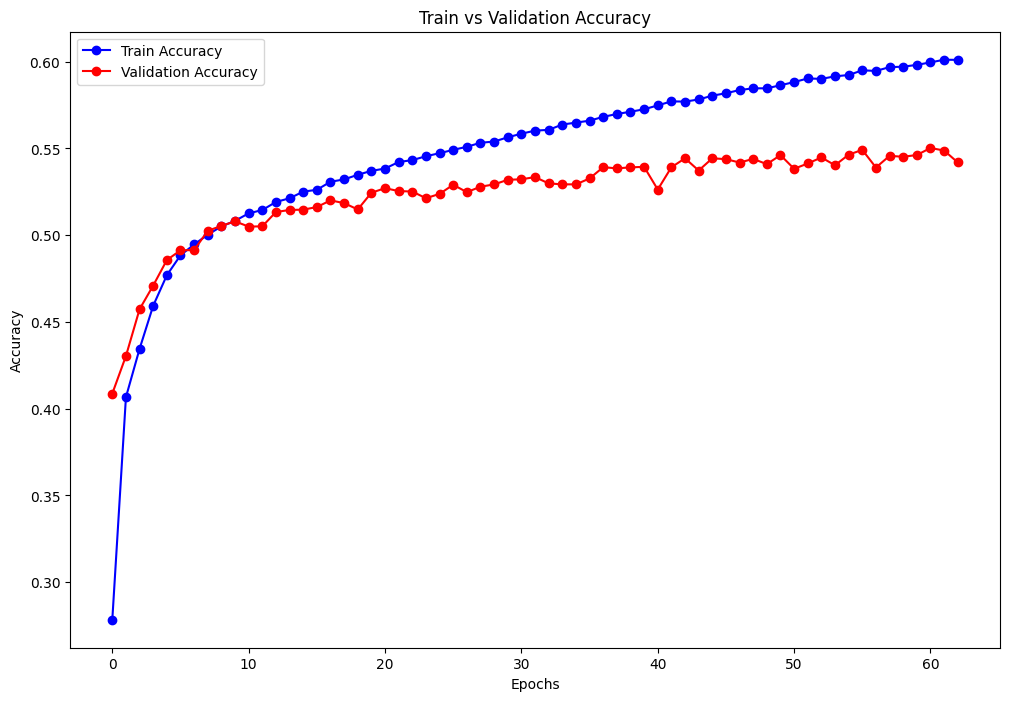

In [ ]:
# Extract the train and validation accuracy from the history dictionary
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create a figure with a single subplot
plt.figure(figsize=(12, 8))

# Plot the train and validation accuracy curves
plt.plot(epochs, train_accuracy, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')

# Add labels and title
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add legend and show the plot
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = mcnet_model.evaluate(X_test, y_test, verbose = 1)

1375/1375 [==============================] - 6s 4ms/step - loss: 1.2257 - accuracy: 0.5453


1375/1375 [==============================] - 5s 3ms/step


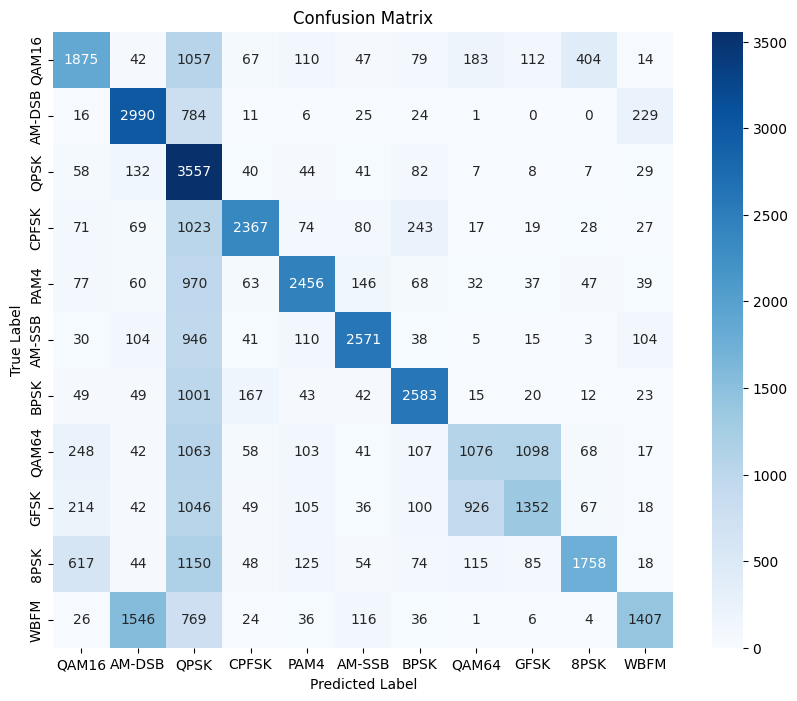

In [ ]:
predictions = mcnet_model.predict(X_test)

# Define the string representations for each label
modulation_labels = ['QAM16', 'AM-DSB', 'QPSK', 'CPFSK', 'PAM4', 'AM-SSB', 'BPSK', 'QAM64', 'GFSK', '8PSK', 'WBFM']

# Convert true labels from one-hot encoded to integer labels
y_test_labels = [np.argmax(label) for label in y_test]

# Convert model predictions to integer labels
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# Convert integer labels to string representations
y_test_labels = [modulation_labels[label] for label in y_test_labels]
predicted_labels = [modulation_labels[label] for label in predicted_labels]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, predicted_labels, labels=modulation_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=modulation_labels, yticklabels=modulation_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Calculate accuracy for each modulation type
modulation_accuracy = {}
for label, predicted in zip(y_test_labels, predicted_labels):
    if label not in modulation_accuracy:
        modulation_accuracy[label] = []
    modulation_accuracy[label].append(label == predicted)

# Print accuracy for each modulation type
for label, accuracy in modulation_accuracy.items():
    print(f"{label}: {np.mean(accuracy):.2f}")

WBFM: 0.35
AM-DSB: 0.73
BPSK: 0.65
QPSK: 0.89
8PSK: 0.43
QAM64: 0.27
CPFSK: 0.59
AM-SSB: 0.65
PAM4: 0.61
GFSK: 0.34
QAM16: 0.47


In [ ]:
# Compute accuracy at each SNR level
snr_labels = np.unique(X_test_snr)
accuracy_by_snr = {}
for snr in snr_labels:
    # Select indices for samples with the current SNR
    snr_indices = np.where(X_test_snr == snr)[0]
    # Get predictions and true labels for the current SNR
    snr_predictions = predictions[snr_indices]
    snr_true_labels = y_test[snr_indices]
    # Convert true labels from one-hot encoded to integer labels
    snr_true_labels = np.argmax(snr_true_labels, axis=1)
    # Compute accuracy for the current SNR
    snr_accuracy = np.mean(np.argmax(snr_predictions, axis=1) == snr_true_labels)
    accuracy_by_snr[snr] = snr_accuracy

# Sort the SNRs and print the accuracy for each
sorted_snrs = np.sort(snr_labels)
for snr in sorted_snrs:
    print(f"SNR: {snr} dB, Accuracy: {accuracy_by_snr[snr]:.2f}")

SNR: -20 dB, Accuracy: 0.10
SNR: -18 dB, Accuracy: 0.09
SNR: -16 dB, Accuracy: 0.11
SNR: -14 dB, Accuracy: 0.12
SNR: -12 dB, Accuracy: 0.16
SNR: -10 dB, Accuracy: 0.22
SNR: -8 dB, Accuracy: 0.31
SNR: -6 dB, Accuracy: 0.43
SNR: -4 dB, Accuracy: 0.58
SNR: -2 dB, Accuracy: 0.67
SNR: 0 dB, Accuracy: 0.75
SNR: 2 dB, Accuracy: 0.79
SNR: 4 dB, Accuracy: 0.83
SNR: 6 dB, Accuracy: 0.82
SNR: 8 dB, Accuracy: 0.84
SNR: 10 dB, Accuracy: 0.83
SNR: 12 dB, Accuracy: 0.83
SNR: 14 dB, Accuracy: 0.82
SNR: 16 dB, Accuracy: 0.82
SNR: 18 dB, Accuracy: 0.82


In [ ]:
mcnet_model.save_weights("/content/drive/MyDrive/Colab_Notebooks/DeepSig/mcnet_weights.h5")